In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches
from detectron2.structures import pairwise_iou, boxes

from detection.inference.detector import lesion_detector, post_process_pred

# SET dataset

The SET dataset form Mexico of 33 patients will be used to assess the performance of the model on a test set outiside of the original distribution.<br>
- SEt images are slightly different to DE, but maintains a similar pixel distribution so we expect similar performance.

In [3]:
## model inputs
config_file = repo_path / 'detection/training/data/config_files/fine_tuning_CEM.yaml'
mod_num = '04'
# model_file = repo_path / f'detection/training/results/real-synth_improved/model_00{mod_num}999.pth' # fine-tuned 2
model_file = repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth'
min_score = 0.1 # minimum score threshold to keep the prediction
## data inputs
im_dir = repo_path / 'data/SET-Mex/images/substracted_jpg'
metadata_path = repo_path / 'data/SET-Mex/metadata/SET_png_metadata.csv'

detector = lesion_detector(config_file, model_file, metadata_path, im_dir, min_score)

[03/05 12:53:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth ...


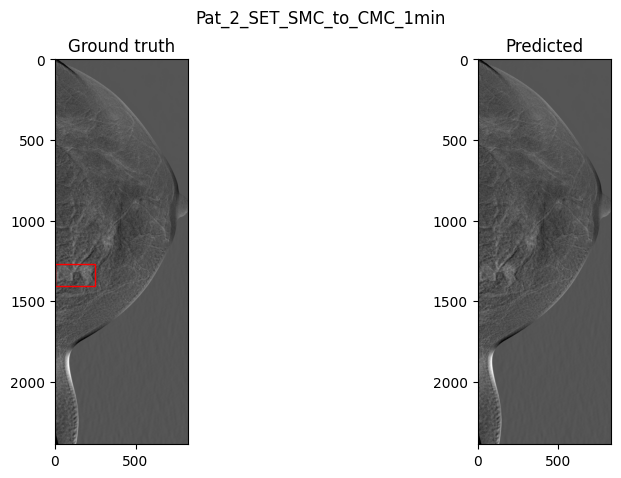

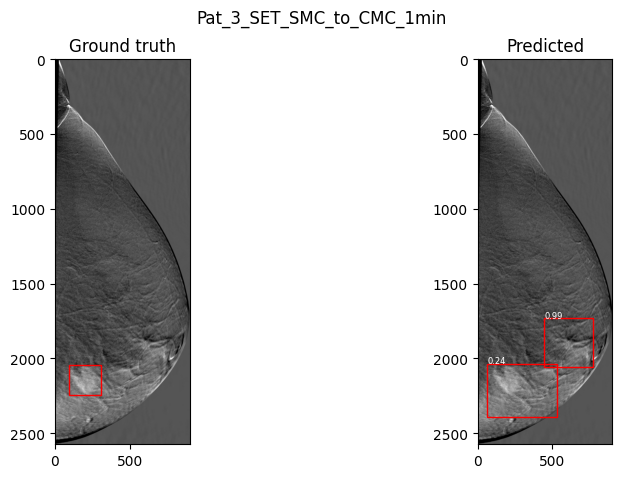

In [5]:
for im_name in detector.test_df['image_name'].unique()[0:2]:

    detector.c_im_name = im_name
    detector.prepare_im_gt()
    detector.predict()
    # detector.c_output = post_process_pred(detector.c_output) # experimental post-processing

    detector.show_c_predictions()

# Computing FROC

We will compute the FROc as described in the CEM detection paper and the similar to the AIA microcalcification approach.

In [3]:
## model inputs
config_file = repo_path / 'detection/training/data/config_files/fine_tuning_CEM.yaml'
mod_num = '04'
# model_file = repo_path / f'detection/training/results/real-synth_improved/model_00{mod_num}999.pth' # fine-tuned 2
model_file = repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth'
min_score = 0.1 # minimum score threshold to keep the prediction
## data inputs
im_dir = repo_path / 'data/SET-Mex/images/substracted_jpg'
metadata_path = repo_path / 'data/SET-Mex/metadata/SET_png_metadata.csv'

detector = lesion_detector(config_file, model_file, metadata_path, im_dir, min_score)

[03/05 17:30:07 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/ricardo/projects/CEM-Detect/data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth ...


    Remember the prediction will be make per image

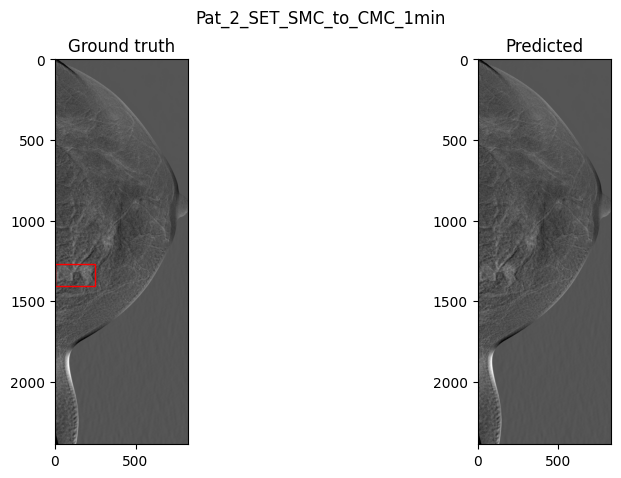

GT_num: 1, Pred_num: 0
[]


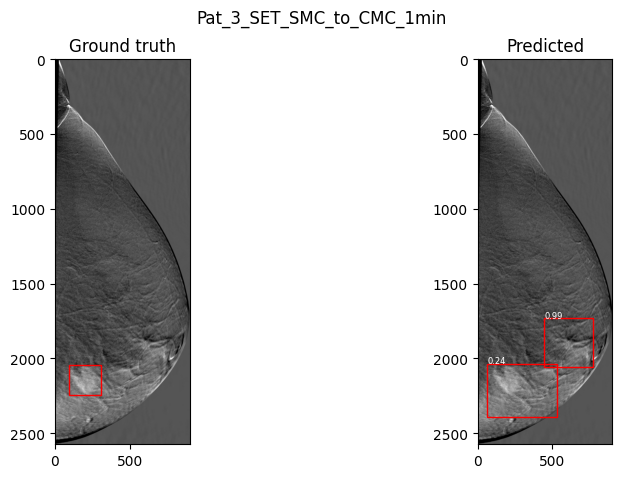

GT_num: 1, Pred_num: 2
[[0.        0.2613491]]


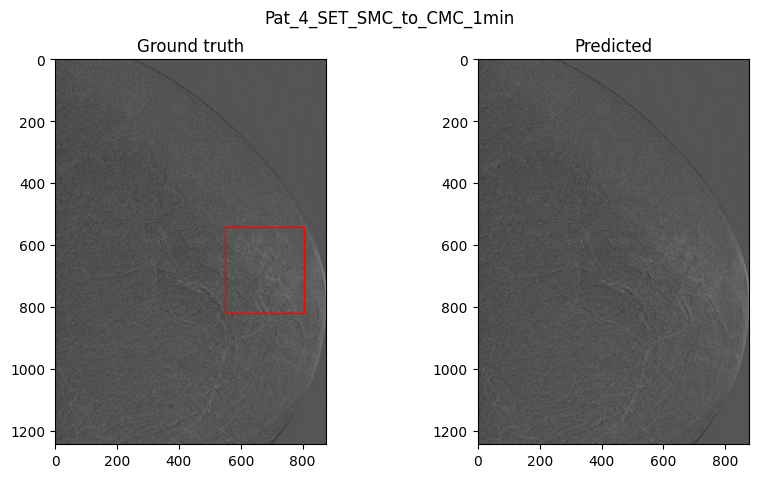

GT_num: 1, Pred_num: 0
[]


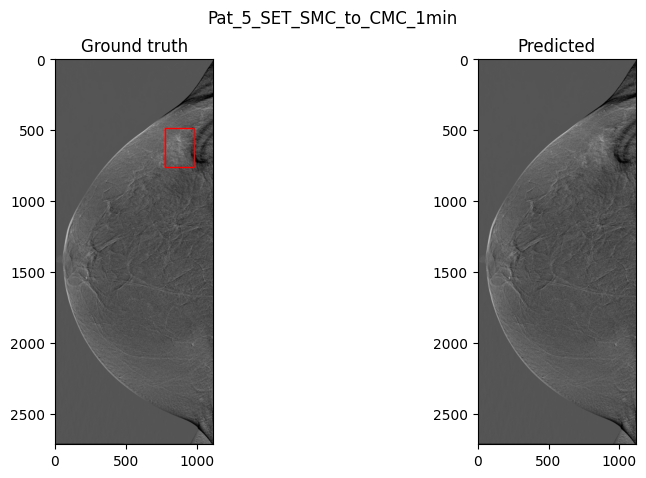

GT_num: 1, Pred_num: 0
[]


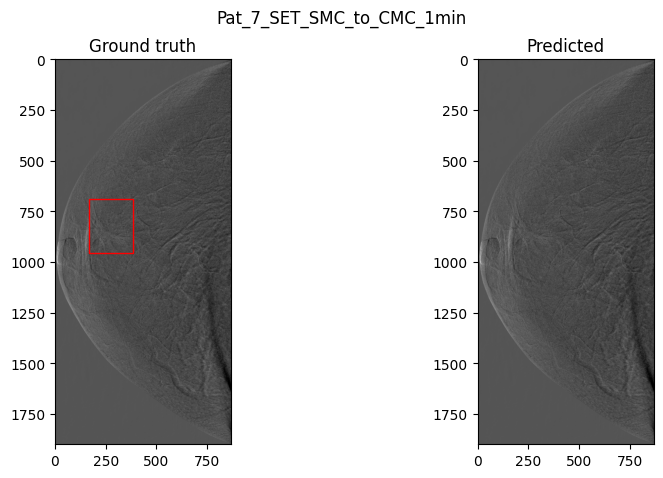

GT_num: 1, Pred_num: 0
[]


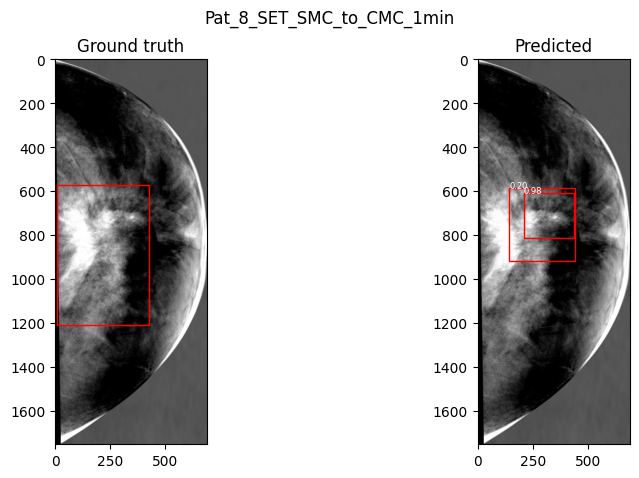

GT_num: 1, Pred_num: 2
[[0.16448528 0.3478027 ]]


IndexError: index -2 is out of bounds for axis 0 with size 1

In [8]:
detector.start_metrics()
for im_name in detector.test_df['image_name'].unique()[0:11]:
    detector.c_im_name = im_name
    detector.prepare_im_gt()
    detector.predict()
    detector.show_c_predictions()
    # mtrics computing
    used_preds = detector.compute_TP_FN_counts(show=True)
    detector.compute_FP_counts(used_preds)

We want to compute the TP, FP and FN (no True negative because thatis not defined).<br>
The detection is defined by the iou value and the probability score.<br>
For the FROC curve:
- The TP and FP will be computed for different thresholds of the probability score.
- The FN is a fixed number (with respect to the threshold) so this value will be computed by itself